In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [4]:
class setup:
    wlen = 0.640 # mkm (light wavelength)
    wlen_err = 0.020 # mkm
    focal = 0.3 # m (focal distance)
    focal_err = 0.01 # m
    mkm_in_del = 4 # (string tuning coeff)
    x_err = 10 # del (string tuning err)
    nu_err = 0.001 # MHz (frequency err)
    
def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [5]:
data = mipt.read_excel('data/432A.ods', usecols=['D', 'E', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q'], header=(0,1)).dropna(how='all')
data

xsl = {
    "F = 1.16 MHz" : "1.16",
    "F = 1.81 MHz" : "1.81",
    "F = 4.10 MHz" : "4.10",
    "F = 4.60 MHz" : "4.60",
    "F = 3.46 MHz" : "3.46",

    "x, del" : "x"
}

data = mipt.map_excel(data, xsl)
data

1.16      1.81      4.10        4.60        3.46       
     N    x    N    x    N      x    N      x    N      x
0   -3    0   -3  -56 -2.0 -137.0 -1.0 -155.0 -1.0 -100.0
1   -2   32   -2    0 -1.0    0.0  0.0    0.0  0.0    0.0
2   -1   65   -1   60  0.0  136.0  1.0  170.0  1.0  110.0
3    0   96    0  110  1.0  268.0  NaN    NaN  NaN    NaN
4    1  143    1  175  2.0  407.0  NaN    NaN  NaN    NaN
5    2  180    2  235  NaN    NaN  NaN    NaN  NaN    NaN
6    3  223    3  290  NaN    NaN  NaN    NaN  NaN    NaN

[1.16, 1.81, 3.46, 4.1, 4.6]
[149.0, 231.85714285714286, 420.0, 542.4, 650.0]
[1494.765100671141, 1498.8539741219963, 1581.7142857142858, 1451.3274336283184, 1358.7692307692307]
[81.67426566378461, 70.32667939936412, 84.36275922204904, 66.57800334244844, 71.8837657929281]
v = (1477 +- 34) m/s


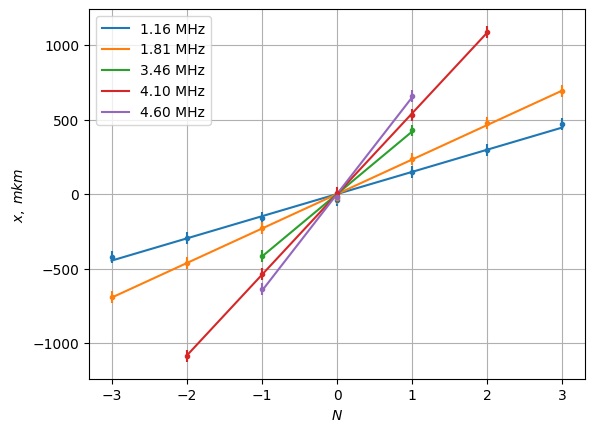

In [20]:
k_arr = []
nu_arr = []
v_arr = []
verr_arr = []

def veloc(x):
    return x[0] * x[1] * x[2] / x[3] * 1e6

def plot(d, nu):
    d = d[nu]
    dx = d["x"].dropna() * setup.mkm_in_del
    dN = d["N"].dropna()

    av = np.mean(dx)
    dx -= av
    mipt.plot(dN, dx, label=nu + " MHz", yerr=setup.x_err * setup.mkm_in_del)
    mnk_dat = mipt.mnk(dN, dx)
    k = mnk_dat.get_data()["a"][0]
    k_err = mnk_dat.get_data()["da"][0]

    k_arr.append(k)
    nu_arr.append(float(nu))
    # v_arr.append(setup.focal * setup.wlen * float(nu) / k * 1e6)

    v_arr.append(veloc([setup.focal, setup.wlen, float(nu), k]))
    err, grad = mipt.errcalc(veloc,
                             [setup.focal, setup.wlen, float(nu), k],
                             [setup.focal_err, setup.wlen_err, setup.nu_err, k_err]
    )
    verr_arr.append(err[0])

plot(data, "1.16")
plot(data, "1.81")
plot(data, "3.46")
plot(data, "4.10")
plot(data, "4.60")

plt.xlabel(r"$N$")
plt.ylabel(r"$x, \; mkm$")
plt.grid(True)
plt.legend()

print(nu_arr)
print(k_arr)
print(v_arr)
print(verr_arr)

v = np.mean(v_arr)
verr = np.linalg.norm(verr_arr) / len(v_arr)

print("v = ({:.0f} +- {:.0f}) m/s".format(v, verr))

(0    1.16
 1    1.81
 2    3.46
 3    4.10
 4    4.60
 dtype: float64,
 0    1494.765101
 1    1498.853974
 2    1581.714286
 3    1451.327434
 4    1358.769231
 dtype: float64,
 None)

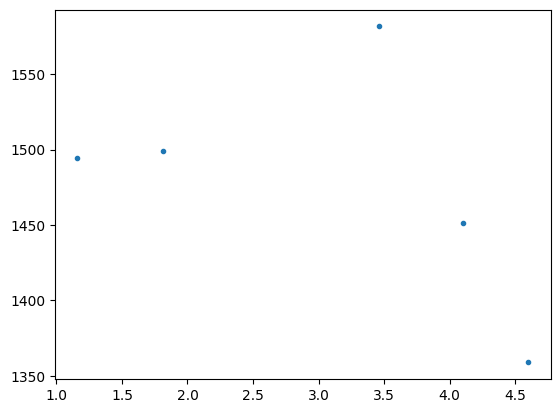

In [89]:
mipt.plot(nu_arr, v_arr, func=None)

## –ó–∞–ø—É—Å–∫–∞—Ç—å –≤—Å–µ —è—á–µ–π–∫–∏ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –∏ —Ä–∞–≤–Ω–æ–º–µ—Ä–Ω–æ...

# –¢–∞–±–ª–∏—Ü–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤

In [50]:
U = data['Uc'].to_numpy().flatten()
E = data['E'].to_numpy().flatten()
C = data['C'].to_numpy().flatten() # –Ω–§
f = data['f0'].to_numpy().flatten() # –ì—Ü

serror = 0.05 / C[0] # -- –ü–æ–≥—Ä–µ—à–Ω–æ—Å—Ç—å –µ–º–∫–æ—Å—Ç–∏ –±—É–¥–µ—Ç –≤–ª–∏—è—Ç—å 
                     # –Ω–∞ –ø–æ–ª–Ω—É—é –ø–æ–≥—Ä–µ—à–Ω–æ—Å—Ç—å –∏–Ω–¥—É–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏, –±–µ—Ä–µ–º –º–∞–∫—Å, –¥–ª—è –æ—Ü–µ–Ω–∫–∏

#
# –í—Å–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø–æ—Å—á–∏—Ç–∞–Ω—ã –ø—Ä–∏ —Ä–µ–∑–æ–Ω–∞–Ω—Å–µ...
#
L = 1/((2 * math.pi * f)**2 * C * 1e-9) * 1e6 # –º–∫–ì–Ω -- –∏–Ω–¥—É–∫—Ç–∏–≤–Ω–æ—Å—Ç—å
rho = 2 * math.pi * f * L * 1e-6 # –û–º -- –≤–æ–ª–Ω–æ–≤–æ–µ —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏–µ –∫–æ–Ω—Ç—É—Ä–∞ 
Q = U / E # -- –¥–æ–±—Ä–æ—Ç–Ω–æ—Å—Ç—å –∫–æ–Ω—Ç—É—Ä–∞
Rsum = rho / Q # –û–º -- —Å—É–º–º–∞—Ä–Ω–æ–µ —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏–µ Rsum = Rs + RL + R (R -- –Ω–∞ —É—Å—Ç–∞–Ω–æ–≤–∫–µ)
Rs = rho * 1e-3 # –û–º -- —ç–∫–≤–∏–≤–∞–ª–µ–Ω—Ç–Ω–æ–µ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–µ —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏–µ (–≠–ü–°) –∫–æ–Ω–¥–µ–Ω—Å–∞—Ç–æ—Ä–∞ 
RL = Rsum - Rs - setup.R # –û–º -- —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏–µ –∫–∞—Ç—É—à–∫–∏
I = E / Rsum # –ê -- —Ç–æ–∫ —á–µ—Ä–µ–∑ —É—Å—Ç–∞–Ω–æ–≤–∫—É (—Ç—É—Ç –¥—Ä—É–≥–æ–≥–æ —Ç–æ–∫–∞ –Ω–µ—Ç)

results_list = {
    'C' : C,
    'f' : f,
    'U' : U,
    'E' : E,
    'L' : L,
    'Q' : Q,
    'rho' : rho,
    'Rsum' : Rsum,
    'RL' : RL,
    'I' : I
}

results_fmt = {
    'C': [r'$C$, –Ω–§', '{:.1f}'],
    'f' :  [r'$f_0$, –ì—Ü', '{:.0f}'],
    'U' :  [r'$U_C$, –í', '{:.2f}'],
    'E' :  [r'$\mathscr{E}$, –í', '{:.1f}'],
    'L' :  [r'$L$, –º–∫–ì–Ω', '{:.1f}'],
    'Q' :  [r'$\mathcal{Q}$', '{:.1f}'],
    'rho' :  [r'$\rho$, –û–º', '{:.1f}'],
    'Rsum' :  [r'$R_{\Sigma}, –û–º$', '{:.1f}'],
    'RL' :  [r'$R_L$, –û–º', '{:.1f}'],
    'I' :  [r'$I$, –ê', '{:.3f}'],
}

L_error = t_coeff(L.size) * L.std() / (L.size)**0.5
RL_error = t_coeff(RL.size) * RL.std() / (RL.size)**0.5
mean_list = {
    'names' : ['$L$, –º–∫–ì–Ω', '$R_L$, –û–º'],
    'mean' : [L.mean(), RL.mean()],
    'std' : [L.std(), RL.std()],
    'error' : [L_error, RL_error],
    'serror' : [(L_error**2 + (L.mean()*serror)**2)**0.5, (RL_error**2 + (RL.mean()*serror)**2)**0.5],
}

RL_full_error = (RL_error**2 + (RL.mean()*serror)**2)**0.5

mean_fmt = {
    'names' :  [r''],
    'mean' :  [r'–°—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ', '{:.1f}'],
    'std' :  [r'–°—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–Ω–æ–µ', '{:.1f}'],
    'error' :  [r'–°–ª—É—á–∞–π–Ω–∞—è –ø–æ–≥—Ä–µ—à–Ω–æ—Å—Ç—å', '{:.1f}'],
    'serror' :  [r'–ü–æ–≥—Ä–µ—à–Ω–æ—Å—Ç—å', '{:.1f}'],
}

results = pd.DataFrame(results_list)
tab = mipt.table(results, results_fmt)
tab.to_latex('gen/setup.tex')
tab.rename().data

mean = pd.DataFrame(mean_list)
mean_tab = mipt.table(mean, mean_fmt)
mean_tab.to_latex('gen/setup-mean.tex')
mean_tab.rename().data
tab.rename().data

$C$, –Ω–§  $f_0$, –ì—Ü  $U_C$, –í  $\mathscr{E}$, –í   $L$, –º–∫–ì–Ω  $\mathcal{Q}$  \
0     33.2    27850.0      4.56               0.2  983.675332          22.80   
1     47.6    23270.0      3.94               0.2  982.744324          19.70   
2     57.5    21160.0      3.65               0.2  983.877643          18.25   
3     68.0    19460.0      3.39               0.2  983.661511          16.95   
4    102.8    15840.0      2.83               0.2  982.057223          14.15   

   $\rho$, –û–º  $R_{\Sigma}, –û–º$  $R_L$, –û–º    $I$, –ê  
0  172.130111          7.549566   3.877436  0.026492  
1  143.686774          7.293745   3.650058  0.027421  
2  130.808698          7.167600   3.536791  0.027903  
3  120.273066          7.095756   3.475483  0.028186  
4   97.739889          6.907413   3.309673  0.028954

# –ê–º–ø–ª–∏—Ç—É–¥–Ω–æ-—á–∞—Å—Ç–æ—Ç–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏

–Ø —Å—á–∏—Ç–∞–ª –¥–ª—è –¥–≤—É—Ö –∑–Ω–∞—á–µ–Ω–∏–π. –ú–µ–Ω—å—à–µ–µ -- low, –±–æ–ª—å—à–µ–µ -- high

C = 33.2 –Ω–§ —Ä–µ–∑–æ–Ω–∞–Ω—Å = 27805 –ì—Ü
C =   68 –Ω–§ —Ä–µ–∑–æ–Ω–∞–Ω—Å = 19427 –ì—Ü


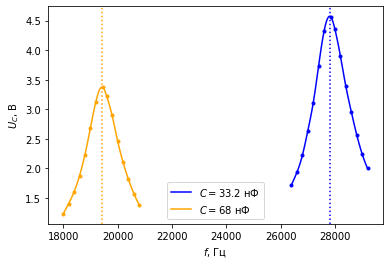

In [30]:
data = mipt.read_excel('data/322.xlsx', usecols=range(4,14), header=(0,1)).dropna()
data

fmt = {
    'low' : [r'$C={0}$ –Ω–§'.format(setup.C_low), '{:.1f}'],
    'high' : [r'$C={0}$ –Ω–§'.format(setup.C_high), '{:.1f}'],
    ('high', 'f') :  [r'$f_0$, –ì—Ü', '{:.0f}'],
    ('high', 'Uc') :  [r'$U_C$, –í', '{:.2f}'],
    ('high', 'x') :  [r'$x$, –¥–µ–ª.', '{:.1f}'],
    ('high', 'x0') :  [r'$x_0$, –¥–µ–ª.', '{:.1f}'],
    ('high', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, –¥–µ–ª.', '{:.2f}'],
    ('low', 'f') :  [r'$f_0$, –ì—Ü', '{:.0f}'],
    ('low', 'Uc') :  [r'$U_C$, –í', '{:.2f}'],
    ('low', 'x') :  [r'$x$, –¥–µ–ª.', '{:.1f}'],
    ('low', 'x0') :  [r'$x_0$, –¥–µ–ª.', '{:.1f}'],
    ('low', 'dF/pi') :  [r'$\frac{\varphi}{\pi}$, –¥–µ–ª.', '{:.2f}'],
}

tab = mipt.table(data, fmt)
tab.to_latex('gen/measure.tex')

tab.rename().data

low = data['low']
high = data['high']

from scipy.interpolate import interp1d
def interp(x, y):
    return interp1d(x, y, kind='cubic')
    
x, y, equ_low = mipt.plot(low['f'], low['Uc'], func=interp, color='blue', label=r'$C={0}$ –Ω–§'.format(setup.C_low))
x, y, equ_high = mipt.plot(high['f'], high['Uc'], func=interp, color='orange', label=r'$C={0}$ –Ω–§'.format(setup.C_high))

low_resonance = op.fmin(lambda x: -equ_low(x), low['f'][0], disp=0)[0]
high_resonance = op.fmin(lambda x: -equ_high(x), high['f'][0], disp=0)[0]

plt.axvline(x=low_resonance, c='blue', ls=':')
plt.axvline(x=high_resonance, c='orange', ls=':')

plt.ylabel(r"$U_C$, –í")
plt.xlabel(r"$f$, –ì—Ü")
plt.legend()
plt.savefig('gen/fig-resonance.pdf')

print('C = {:4} –Ω–§ —Ä–µ–∑–æ–Ω–∞–Ω—Å = {:.0f} –ì—Ü'.format(setup.C_low, low_resonance))
print('C = {:4} –Ω–§ —Ä–µ–∑–æ–Ω–∞–Ω—Å = {:.0f} –ì—Ü'.format(setup.C_high, high_resonance))

# –ê–º–ø–ª–∏—Ç—É–¥–Ω–æ-—á–∞—Å—Ç–æ—Ç–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –≤ –±–µ–∑—Ä–∞–∑–º–µ—Ä–Ω—ã—Ö –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∞—Ö

C = 33.2 –Ω–§ 
—à–∏—Ä–∏–Ω–∞ = 1.0224 - 0.9781 = 0.0443
Q = 22.57870818478546 +- 0.4515741636957092
C =   68 –Ω–§ 
—à–∏—Ä–∏–Ω–∞ = 1.0300 - 0.9697 = 0.0603
Q = 16.5711552304821 +- 0.33142310460964197


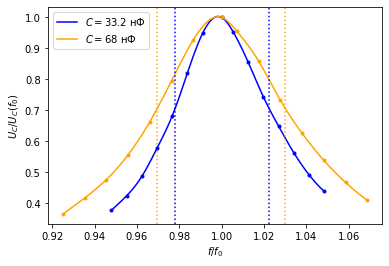

In [31]:
# Warning! –ù—É–∂–Ω–æ –∑–∞–ø—É—Å—Ç–∏—Ç—å –ø—Ä–µ–¥—ã–¥—É—â—É—é —è—á–µ–π–∫—É —á—Ç–æ–± —Ç—É—Ç –±—ã–ª–∞ —Ñ—É–Ω–∫—Ü–∏–∏ –∏–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏–∏ equ_low –∏ equ_high

data = mipt.read_excel('data/322.xlsx', usecols=range(4,14), header=(0,1)).dropna()
settings = mipt.read_excel('data/322.xlsx', usecols=range(0,4), header=(0)).dropna()
low = data['low']
high = data['high']

# –í—ã—á–ª–µ–Ω–∏–º —Ä–µ–∑–æ–Ω–∞–Ω—Å–Ω—ã–µ —á–∞—Å—Ç–æ—Ç—ã
f0_low  = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_low ].tolist()[0]]
f0_high = settings['f0'].tolist()[settings.index[settings['C'] == setup.C_high].tolist()[0]]

x_low = low['f']/f0_low
x_high = high['f']/f0_high

y_low = equ_low(low['f']) / equ_low(f0_low)
y_high = equ_high(high['f']) / equ_high(f0_high)

x, y, norm_low = mipt.plot(x_low, y_low, func=interp, color='blue', label=r'$C={0}$ –Ω–§'.format(setup.C_low))
x, y, norm_high = mipt.plot(x_high, y_high, func=interp, color='orange',label=r'$C={0}$ –Ω–§'.format(setup.C_high))

low_right = op.fsolve(lambda x: norm_low(x) - 0.707, 1.01)[0]
low_left = op.fsolve(lambda x: norm_low(x) - 0.707, 0.99)[0]

high_right = op.fsolve(lambda x: norm_high(x) - 0.707, 1.01)[0]
high_left = op.fsolve(lambda x: norm_high(x) - 0.707, 0.99)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

plt.ylabel(r"$U_C/U_C(f_0)$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-resonance-norm.pdf')


Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

print('C = {:4} –Ω–§ \n—à–∏—Ä–∏–Ω–∞ = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, 2e-2 * Q_low))

print('C = {:4} –Ω–§ \n—à–∏—Ä–∏–Ω–∞ = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, 2e-2 * Q_high))

# –§–∞–∑–æ–≤–æ-—á–∞—Å—Ç–æ—Ç–Ω—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ 

In [32]:
# Warning! –ù—É–∂–Ω–æ –∑–∞–ø—É—Å—Ç–∏—Ç—å –ø—Ä–µ–¥—ã–¥—É—â—É—é —è—á–µ–π–∫—É

C = 33.2 –Ω–§ 
—à–∏—Ä–∏–Ω–∞ = 1.0253 - 0.9770 = 0.0484
Q = 20.6724631979196 +- 0.40298119769026586
C =   68 –Ω–§ 
—à–∏—Ä–∏–Ω–∞ = 1.0388 - 0.9697 = 0.0692
Q = 14.455377725814989 +- 0.1953429422407431


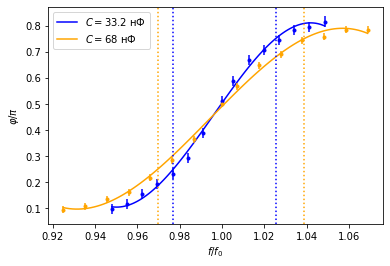

In [42]:
phi_low  = low['dF/pi']
phi_high = high['dF/pi']

from scipy.interpolate import UnivariateSpline
def interp(x, y):
    return UnivariateSpline(x, y, s=0.1)

x, y, fphi_low = mipt.plot(x_low, phi_low, yerr = phi_low * 0.5 / low['x'], func=interp, color='blue', label=r'$C={0}$ –Ω–§'.format(setup.C_low))
x, y, fphi_high = mipt.plot(x_high, phi_high, yerr = phi_high * 0.5 / high['x'], func=interp, color='orange',label=r'$C={0}$ –Ω–§'.format(setup.C_high))

low_right = op.fsolve(lambda x: fphi_low(x) - 3/4, 1)[0]
low_left = op.fsolve(lambda x: fphi_low(x) - 1/4, 1)[0]

high_right = op.fsolve(lambda x: fphi_high(x) - 3/4, 1)[0]
high_left = op.fsolve(lambda x: fphi_high(x) - 1/4, 1)[0]

plt.axvline(x=low_right, c='blue', ls=':')
plt.axvline(x=low_left, c='blue', ls=':')

plt.axvline(x=high_right, c='orange', ls=':')
plt.axvline(x=high_left, c='orange', ls=':')

Q_low = 1 / (low_right - low_left)
Q_high = 1 / (high_right - high_left)

plt.ylabel(r"$\varphi/\pi$")
plt.xlabel(r"$f/f_0$")
plt.legend()
plt.savefig('gen/fig-phase.pdf')

print('C = {:4} –Ω–§ \n—à–∏—Ä–∏–Ω–∞ = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_low, low_right, low_left, low_right - low_left))
print('Q = {} +- {}'.format(Q_low, (phi_low * 0.5 / low['x']).mean() * Q_low))

print('C = {:4} –Ω–§ \n—à–∏—Ä–∏–Ω–∞ = {:.4f} - {:.4f} = {:.4f}'.format(setup.C_high, high_right, high_left, high_right - high_left))
print('Q = {} +- {}'.format(Q_high, (phi_high * 0.5 / high['x']).mean() * Q_high))

# –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç—å ùëÖùêø(ùúà0ùëõ) –≤ —Å–∏—Å—Ç–µ–º–µ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç —Å –Ω–∞—á–∞–ª–æ–º –≤ —Ç–æ—á–∫–µ (0,6ùúà07; 0);

Text(0.5, 0, '$f$, –ì—Ü')

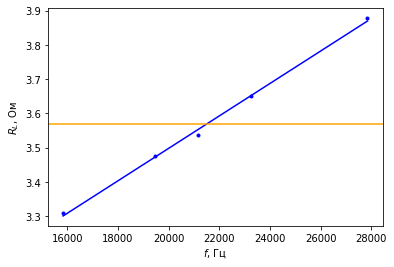

In [90]:
# –Ø –Ω–∞ —ç—Ç—É —Ñ–∏–≥–Ω—é –ø–æ–¥–∑–∞–±–∏–ª, –Ω–æ –ø—Ä–∏ –∂–µ–ª–∞–Ω–∏–∏ -- —Å–æ—Ö—Ä–∞–Ω—è–π

mipt.plot(f, RL, color='blue')
plt.axhline(y=RL.mean(), color='orange')

plt.ylabel(r"$R_L$, –û–º")
plt.xlabel(r"$f$, –ì—Ü")
# plt.savefig('gen/fig-rl.pdf') <-- Delete comment here